In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import fuzz

In [361]:
df = pd.read_csv("./data/stayzilla_com-travel_sample.csv")
df = df.drop(['sitename','uniq_id'], axis = 1)

We have two different datasets to work with, one focused on India and one in Brazil. The endgoal is to combine the two together. We'll start with the Indian dataset from Stayzilla.com.

## 1.0: Stayzilla Overview

### 1.1: Sample and shape

In [362]:
df.head(5)

,additional_info,amenities,check_in_date,check_out_date,city,country,crawl_date,description,highlight_value,hotel_star_rating,...,property_type,qts,query_time_stamp,room_price,room_types,search_term,service_value,similar_hotel,things_to_do,things_to_note
0,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper,04-08-2016,05-08-2016,Kalimpong,India,2016-07-20,Sangsey Valley Resort is Located at the wonder...,NaN,NaN,...,Resort,2016-07-20 10:59:55 +0000,2016-07-20 10:59:55 +0000,3167per night incl. tax,3 Bedded Room,NaN,Not Verified,NaN,NaN,"All taxes.|Complimentary Breakfast, Lunch and ..."
1,Acceptance Rate:100 percent|Response Time:< 6 ...,Parking|AC,04-08-2016,05-08-2016,Kanpur,India,2016-07-20,What should you know? Enjoy unmatched service ...,NaN,NaN,...,Hotel,2016-07-20 10:59:55 +0000,2016-07-20 10:59:55 +0000,815per night incl. tax,Double Non-A/C Rooms,NaN,Not Verified,Hotel Mangalam|Hotel Maha Roopa Palace,NaN,Kindly Note:|This Tariff is not applicable for...
2,Acceptance Rate:100 percent|Response Time:< 6 ...,Pickup & Drop|Parking|AC,04-08-2016,05-08-2016,Jodhpur,India,2016-07-20,"What should you know? A budget hotel, this acc...",NaN,NaN,...,Hotel,2016-07-20 10:59:55 +0000,2016-07-20 10:59:55 +0000,1624per night incl. tax,Deluxe AC Double,NaN,Not Verified,Gouri Heritage Haveli|The Regent Hotel|Vista R...,NaN,All taxes.|Complimentary Tea.
3,Acceptance Rate:100 percent|Response Time:< 6 ...,WiFi|Newspaper|Pickup & Drop|Gym|Parking|AC,04-08-2016,05-08-2016,Jalpaiguri,India,2016-07-20,What should you know? The Riverwood Forest Ret...,NaN,NaN,...,Hotel,2016-07-20 10:59:55 +0000,2016-07-20 10:59:55 +0000,3509per night incl. tax,Premium Single A/c,NaN,Not Verified,NaN,NaN,All taxes|Complimentary Breakfast|Kindly Note:...
4,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper|AC,04-08-2016,05-08-2016,Kanpur,India,2016-07-20,What should you know? Located at a walking dis...,NaN,NaN,...,Hotel,2016-07-20 10:59:55 +0000,2016-07-20 10:59:55 +0000,5802per night incl. tax,Deluxe AC Double,NaN,Not Verified,Hotel Royal Cliff,NaN,Complimentary Breakfast.|Complimentary WiFi.|C...


In [363]:
df.shape

(1207, 31)

The dataset is a conglomoration of text and dates; these values will need to be cleaned before any real analysis is done. There are 1207 observations and about 32 features. 

### 1.2: Split DataSet

In [364]:
df.iloc[1137:,:].head(5)

,additional_info,amenities,check_in_date,check_out_date,city,country,crawl_date,description,highlight_value,hotel_star_rating,...,property_type,qts,query_time_stamp,room_price,room_types,search_term,service_value,similar_hotel,things_to_do,things_to_note
1137,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper,04-08-2016,05-08-2016,Lucknow,India,2016-07-20,What should you know? Situated 13 km away from...,NaN,NaN,...,Hotel,2016-07-20 11:21:02 +0000,2016-07-20 11:21:02 +0000,2446per night incl. tax,Executive Single,NaN,Not Verified,Hotel Modman Inn,NaN,Complimentary Breakfast.|Complimentary Wifi.|K...
1138,Acceptance Rate:100 percent|Response Time:< 6 ...,Parking|AC,04-08-2016,05-08-2016,Lucknow,India,2016-07-20,What should you know? Hotel Anant attempts to ...,NaN,NaN,...,Hotel,2016-07-20 11:21:02 +0000,2016-07-20 11:21:02 +0000,463per night incl. tax,Dormitory Non AC Per Bed,NaN,Not Verified,Hotel Elora|Hotel Diamond|Hotel Galaxy Interna...,NaN,NaN
1139,~ All taxes.,Restaurent | Car Parking,06/01/2016,09/01/2016,Karnal,NaN,NaN,NaN,What should you know?\n The hotel is situated ...,0.0,...,Hotel,NaN,2015-12-30 15:21:16 +0000,NaN,Double Non A/c Room | Double A/c Room,Karnal,Parking | 24 hour check in | 24 hour check out,NaN,Restaurant,NaN
1140,~ Complimentary Breakfast.~ Complimentary Wifi...,Restaurent | Swimming Pool | Laundry | Pickup ...,06/01/2016,09/01/2016,Kovalam,NaN,NaN,NaN,NaN,0.0,...,Hotel,NaN,2015-12-30 15:21:16 +0000,NaN,Double Non A/c Room | Double A/c Room | A/c Su...,Kovalam,Laundry | Pickup And Drop,NaN,Restaurant | Swimming Pool,NaN
1141,~ All taxes~ Welcome drink on arrival~ Complim...,Restaurent | Bar/Pub | Wifi | Credit Card | La...,06/01/2016,09/01/2016,Shimla,NaN,NaN,NaN,What should you know?\n Hotel Shingar is a ple...,0.0,...,Hotel,NaN,2015-12-30 15:21:16 +0000,NaN,Deluxe Double | Super Deluxe Double | Luxury...,Shimla,Laundry | Free Newspaper,NaN,Restaurant | Bar,NaN


There is a clear split in the observations in the dataset beginning at index 1139; from that point onwards, observations have a different layout and have a pattern of missing values, which will be addressed shortly. This problem definitely needs to be addressed. 

### 1.3: Missing Values

In [365]:
df.isna().sum().sum()

8658

There are over 8500 missing values in the dataset, meaning that said dataset is over 20% missing values. As mentioned previously, they are NOT randomly distributed. You can see this below:

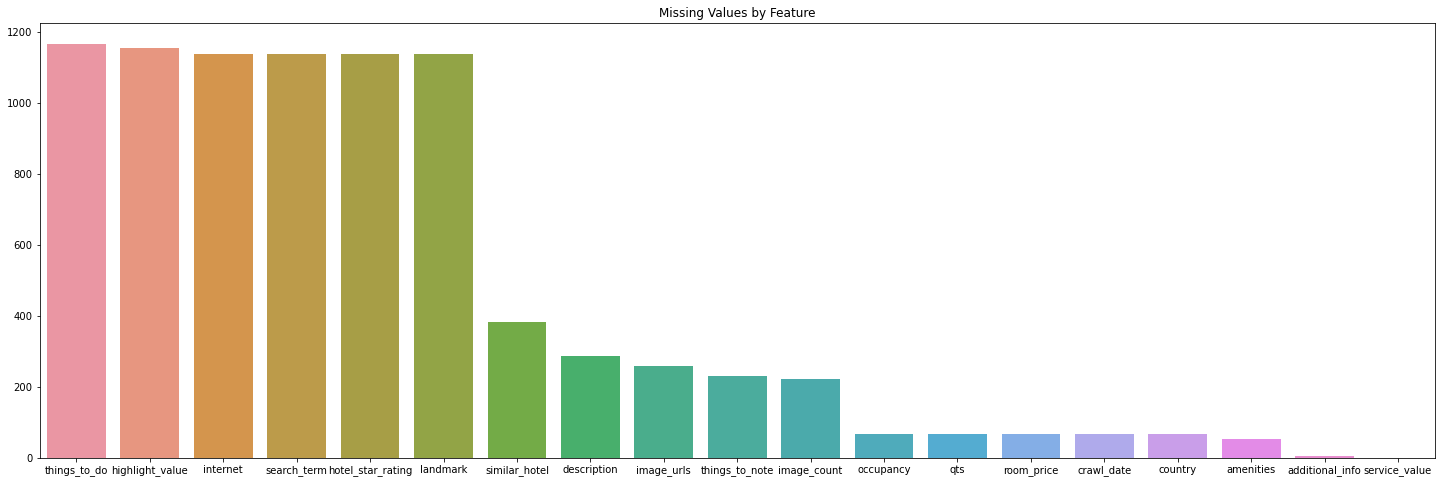

In [366]:
missings = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False)

plt.figure(figsize=(25,8))
plt.title("Missing Values by Feature")
sns.barplot(x = list(missings.index), y = list(missings.values));

Some of these features being cluttered by this are worrying, especially internet and star rating. We need to see later if we can salvage these. Both are very important. 

The others, as we will see below, overlap somewhat in functionality, so we can likely work with them despite their shortcomings.

### 1.4: Misleading Values

In [367]:
df[['additional_info', 'amenities','internet','things_to_do','things_to_note']].iloc[4:,:]

,additional_info,amenities,internet,things_to_do,things_to_note
4,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper|AC,NaN,NaN,Complimentary Breakfast.|Complimentary WiFi.|C...
5,Acceptance Rate:100 percent|Response Time:< 6 ...,WiFi|Free Breakfast|Newspaper|AC,NaN,NaN,CP - Complementary Breakfast.|MAP - Complement...
6,Acceptance Rate:100 percent|Response Time:< 6 ...,WiFi,NaN,NaN,All taxes.|Complimentary Break Fast.
7,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper|AC,NaN,NaN,All taxes.|Complimentary Breakfast Will be Pro...
8,Acceptance Rate:100 percent|Response Time:> 24...,Newspaper|AC,NaN,NaN,All taxes.|Complimentary Wifi.|Kindly Note:|Ex...
...,...,...,...,...,...
1202,~ All Taxes.~ Complimentary Bed Tea.~ Complime...,Restaurent | Business Center | Wifi | Swimming...,Free Internet,Restaurant | Swimming Pool | Health Club,NaN
1203,~ All Taxes,Wifi | Laundry | Car Parking,Free Internet,NaN,NaN
1204,Kindly Note ~ Hotel doesn't have Restaurants i...,Laundry | Car Parking,Internet not present,NaN,NaN
1205,~ All taxes.~ Complimentary WiFi. And Bed Tea;...,Wifi | Credit Card | Laundry | Free Newspaper ...,Free Internet,NaN,NaN


As you can see above, the internet feature should be binary, but missing values represent a large quantity (over 90%) of values. This is due to the aforementioned split. The attribute's information is displayed elsewhere, depending on the hotel in question. I have found it in all of the above features. 

I personally recommend that we split these attributes into their own specific binary features. (Similar to a one hot encoding scenario). This is especially the case for the has/has no internet case mentioned previously; we can add a new feature called Wifi, check each observation for a positive identifier, and use that logic to fill in the values for the new attribute. 

## 2.0: The Brazilian Airbnb Dataset

In [368]:
br = pd.read_csv("./data/brazil_listings.csv")

### 2.1:  Overview

In [369]:
print('Dataset shape: ',br.shape, '\n')
br.head()

Dataset shape:  (33715, 106) 



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20191122092441,2019-11-22,Very Nice 2Br - Copacabana - WiFi,Pls note that special rates apply for Carnival...,- large balcony which looks out on pedestrian ...,Pls note that special rates apply for Carnival...,none,This is the best spot in Rio. Everything happe...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,2.13
1,25026,https://www.airbnb.com/rooms/25026,20191122092441,2019-11-22,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,f,f,strict_14_with_grace_period,t,t,3,3,0,0,2.04
2,31560,https://www.airbnb.com/rooms/31560,20191122092441,2019-11-22,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,2.38
3,35636,https://www.airbnb.com/rooms/35636,20191122092441,2019-11-22,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,2.28
4,35764,https://www.airbnb.com/rooms/35764,20191122092441,2019-11-22,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,2.84


This dataset seems to be much fatter than our other one (~34000 observations vs. ~1200 observations). There are also far more features here, but many seem ancilliary. 

### 2.2: Missing Values

In [370]:
br.isna().sum().sum()

686685

We've got about 700,000 missing values here. Like the prior dataset, these also do not seem to be random. The missing values are primarily concentrated on, thankfully, useless features, but the missing values in the pricing and locale attributes are concerning. 

In [371]:
br.isna().sum().sort_values(ascending = False).head(35)

medium_url                      33715
host_acceptance_rate            33715
jurisdiction_names              33715
xl_picture_url                  33715
thumbnail_url                   33715
neighbourhood_group_cleansed    33715
license                         33713
square_feet                     33220
weekly_price                    31169
monthly_price                   30890
notes                           22468
access                          17683
host_about                      17543
interaction                     16913
house_rules                     16291
review_scores_checkin           15441
review_scores_accuracy          15440
review_scores_location          15438
review_scores_value             15437
review_scores_cleanliness       15435
review_scores_communication     15435
review_scores_rating            15422
transit                         14976
neighborhood_overview           14877
security_deposit                14780
reviews_per_month               14566
first_review

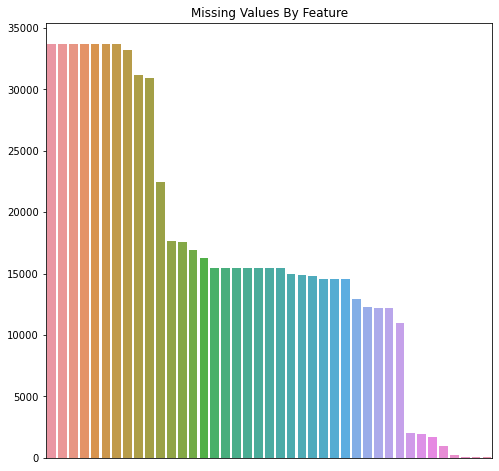

In [372]:
missings = br.isna().sum()[br.isna().sum() > 50].sort_values(ascending = False)

plt.figure(figsize=(8,8))
figure = sns.barplot(x = missings.index, y = missings.values)
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.title("Missing Values By Feature");

We have a dataset where missing value counts are shared across features, meaning that they are not random. They are also plentiful; I hid the feature names, normally on the x axis, because it would be illegible due to the sheer number and overlap of names.

## 3.0: Cleaning the Two Datasets

### 3.1: Choosing Features

In [373]:
## Remove features from Indian dataset that don't add information for comparison purposes
df.drop(['description','highlight_value','image_count','image_urls','property_id','qts','pageurl', 'query_time_stamp','similar_hotel','property_address','search_term','landmark','city','latitude','longitude','property_name','check_in_date', 'check_out_date','crawl_date'], axis = 1, inplace = True)

## Reduce Brazilian dataset to features that match those of the Indian dataset
br = br[['country','property_type','room_type','accommodates','amenities','price','review_scores_rating']]

I found features that provided the greatest amount of overlap between the two datasets, provided of course that they were not standins for the country label. For example, the 'crawl_date' attributes in both sets allow you to easy distinguish between the two because one took place in 2016 and the other 2019. Additionally, that feature provides little to no informational value.

In [374]:
print('Indian Stayzilla.com Dataset', '\n')
df.head()

Indian Stayzilla.com Dataset 



,additional_info,amenities,country,hotel_star_rating,internet,occupancy,property_type,room_price,room_types,service_value,things_to_do,things_to_note
0,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper,India,NaN,NaN,3 Adults 2 Kids,Resort,3167per night incl. tax,3 Bedded Room,Not Verified,NaN,"All taxes.|Complimentary Breakfast, Lunch and ..."
1,Acceptance Rate:100 percent|Response Time:< 6 ...,Parking|AC,India,NaN,NaN,2 Adults 2 Kids,Hotel,815per night incl. tax,Double Non-A/C Rooms,Not Verified,NaN,Kindly Note:|This Tariff is not applicable for...
2,Acceptance Rate:100 percent|Response Time:< 6 ...,Pickup & Drop|Parking|AC,India,NaN,NaN,2 Adults 2 Kids,Hotel,1624per night incl. tax,Deluxe AC Double,Not Verified,NaN,All taxes.|Complimentary Tea.
3,Acceptance Rate:100 percent|Response Time:< 6 ...,WiFi|Newspaper|Pickup & Drop|Gym|Parking|AC,India,NaN,NaN,1 Adult 2 Kids,Hotel,3509per night incl. tax,Premium Single A/c,Not Verified,NaN,All taxes|Complimentary Breakfast|Kindly Note:...
4,Acceptance Rate:100 percent|Response Time:< 6 ...,Newspaper|AC,India,NaN,NaN,2 Adults 2 Kids,Hotel,5802per night incl. tax,Deluxe AC Double,Not Verified,NaN,Complimentary Breakfast.|Complimentary WiFi.|C...


In [375]:
print('Brazilian Airbnb Dataset', '\n')
br.head()

Brazilian Airbnb Dataset 



,country,property_type,room_type,accommodates,amenities,price,review_scores_rating
0,Brazil,Condominium,Entire home/apt,5,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$332.00,93.0
1,Brazil,Apartment,Entire home/apt,2,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$160.00,94.0
2,Brazil,Apartment,Entire home/apt,3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$273.00,96.0
3,Brazil,Apartment,Entire home/apt,3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$378.00,94.0
4,Brazil,Loft,Entire home/apt,2,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",$130.00,98.0


So this is what we have starting out. Now we need to shape each of these features so that they are aligned and comparable

### 3.2: Fixing the Country, Price, and Rating Problems

In [376]:
pd.concat((df[['country','room_price','hotel_star_rating']], br[['country','price','review_scores_rating']]), axis = 1).head()

,country,room_price,hotel_star_rating,country,price,review_scores_rating
0,India,3167per night incl. tax,NaN,Brazil,$332.00,93.0
1,India,815per night incl. tax,NaN,Brazil,$160.00,94.0
2,India,1624per night incl. tax,NaN,Brazil,$273.00,96.0
3,India,3509per night incl. tax,NaN,Brazil,$378.00,94.0
4,India,5802per night incl. tax,NaN,Brazil,$130.00,98.0


I added the country, price, and rating features from both datasets for comparison. For the most part, they suffer from similar problems. The country attributes should be uniform, as in there should be only one label per set; this currently is not the case, but it will be. 

### 3.2.1: Country

In [377]:
list(df['country'].unique())

['India', nan]

In the Stayzilla dataset, we have missing values. Normally I would be hesitant to fill in missing values for a dataset that has not been split yet, but this is the planned target feature of a soon-to-be-merged dataset. The original Stayzilla dataset, we know, sits entirely within India, so, I feel comfortable with filling them in as Indian. 

In [378]:
list(br['country'].unique())

['Brazil', 'Dominica']

In [379]:
br[br['country'] == 'Dominica']

,country,property_type,room_type,accommodates,amenities,price,review_scores_rating
25786,Dominica,Condominium,Entire home/apt,6,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",$756.00,NaN


Strangely the Brazilian Dataset has a posting from the Dominican Republic. We'll create a list of problematic observations for removal, add this value, and then purge our respective datasets of them before merging. 

In [380]:
outlier = 25786

df['country'] = 'India'
br['country'] = 'Brazil'

Easy start; now both labels are uniform across their respective datasets.

### 3.2.2: Room Price

In [381]:
pd.concat((df['room_price'], br['price']), axis = 1).head()

,room_price,price
0,3167per night incl. tax,$332.00
1,815per night incl. tax,$160.00
2,1624per night incl. tax,$273.00
3,3509per night incl. tax,$378.00
4,5802per night incl. tax,$130.00


The prices are shown as strings and need to be converted into floating point numbers. Additionally, we are working with different currencies: the Indian rupee on the left and the Brazilian real on the right (the dollar sign threw me off at the start). We need to solve both of these problems.

In [382]:
# India - room price - convert to integer after dropping string segments
df['room_price'] = pd.to_numeric(df['room_price'].str.replace('p.*', '', regex = True))

# Brazil - price - convert into integer
br['price'] = pd.to_numeric(br['price'].str.replace('$','').str.replace(',',''))

exchange_rate = 13.5
br['price'] = br['price'] * exchange_rate

In [383]:
pd.concat((df['room_price'], br['price']), axis = 1).head()

,room_price,price
0,3167.0,4482.0
1,815.0,2160.0
2,1624.0,3685.5
3,3509.0,5103.0
4,5802.0,1755.0


As you can see, both of these numbers are now floating point values. I converted the Brazilian real into the Indian rupee using the nominal exchange rate between the two currencies. 

Now I can say that the first observation in the Brazilian dataset has a higher daily price than the first observation in the Indian dataset.

### 3.2.3: Ratings

Lastly, the come to the star rating scores. In the EDA, I mentioned I was worried about this feature in the Indian dataset due to the number of missing values it has. The Brazilian Airbnb set has a few missing values but no real issues besides that. Whether or not either could be used depends entirely on the Indian set.

In [384]:
print(df['hotel_star_rating'].fillna(-1).value_counts())

df.drop('hotel_star_rating', axis = 1, inplace = True)
br.drop('review_scores_rating', axis = 1, inplace = True)

-1.0    1139
 0.0      46
 3.0      16
 4.0       3
 2.0       2
 1.0       1
Name: hotel_star_rating, dtype: int64


It cannot; more than 1100 of the values are missing (shown as -1 in this case). Remember that this is out of a total of little more than 1200 records, so the vast majority of the feature is missing. Sadly, this also means that the Brazilian Airbnb's ratings features are also surplus. 

### 3.3: Occupancy

In [385]:
pd.concat((df['occupancy'],br['accommodates']), axis = 1, names = ['India', 'Brazil']).head()

,occupancy,accommodates
0,3 Adults 2 Kids,5
1,2 Adults 2 Kids,2
2,2 Adults 2 Kids,3
3,1 Adult 2 Kids,3
4,2 Adults 2 Kids,2


Next up is the occupancy feature. To align these two, we need to convert the first into an integer value (the sum of the two mentioned in the string).

In [386]:
# split occupancy and then add back together as integers
df['occupancy'].fillna('0 0', inplace = True)
df['occupancy'] = df['occupancy'].str.replace('\D|/w', '', regex = True)


df['accommodates'] = df.occupancy.apply(lambda row_val: (int(row_val[0]) + int(row_val[1])))
br['accommodates'] = pd.to_numeric(br['accommodates'])

df = df.drop(['occupancy'], axis = 1)
df['accommodates'].replace(0, np.nan, inplace = True)

In [387]:
pd.concat((df['accommodates'],br['accommodates']), axis = 1, names = ['India', 'Brazil']).head()

,accommodates,accommodates
0,5.0,5
1,4.0,2
2,4.0,3
3,3.0,3
4,4.0,2


That turned out well; now they are comparable. 

Those observant may have noticed that I tranformed missing values into zeroes before reverting them back into missing values. I did this over the traditional methods of dealing with missing values because this dataset has not been split yet. My job is to clean the data and merge the two sets before sending it on towards those who would like to train a model on it. Imputing the missing values before splitting the data would cause data leakage and ruin the experiment. 

### 3.4: Amenities as Binary Features

This goal is the most difficult of the lot; each post has a list of amenities and the like that serves as marketing material. Moving forward, we want to provide each of these amenities with a binary feature. 

The difficult parts of this are:
    
    1. Identifying all of the important amenities held by both of the datasets
    
    2. Dealing with the fact that the Indian dataset has about four features dedicated towards this goal (we need to combine them) 
    
Let's take a look at each.

### 3.4.1: ID Important Amenities

Before looking at the features, their strings need to be cleaned or we'll be overloaded with information. This also gives us the chance to fill in missing values and combine similar features. 

In [388]:
pd.concat((df['additional_info'].tail(),df['things_to_note'].head()), axis = 1)

,additional_info,things_to_note
0,NaN,"All taxes.|Complimentary Breakfast, Lunch and ..."
1,NaN,Kindly Note:|This Tariff is not applicable for...
2,NaN,All taxes.|Complimentary Tea.
3,NaN,All taxes|Complimentary Breakfast|Kindly Note:...
4,NaN,Complimentary Breakfast.|Complimentary WiFi.|C...
1202,~ All Taxes.~ Complimentary Bed Tea.~ Complime...,NaN
1203,~ All Taxes,NaN
1204,Kindly Note ~ Hotel doesn't have Restaurants i...,NaN
1205,~ All taxes.~ Complimentary WiFi. And Bed Tea;...,NaN
1206,NaN,NaN


As you can see, these two features use similar phrasing and can easily be joined (this was likely caused by that aforementioned split). The only difference is their usage of special characters, which will not be a problem for long.

In [389]:
df['things_to_do'] = df['things_to_do'].fillna(' 0 ')
df['things_to_do'] = df['things_to_do'].str.replace('|', '').str.replace('/',' ').str.lower()

df['amenities'] = df['amenities'].fillna(' 0 ')
df['amenities'] = df['amenities'].str.replace('|', ' ').str.replace('&', '').str.replace('/', ' ').str.lower()

df['service_value'] = df['service_value'].fillna(' 0 ')
df['service_value'] = df['service_value'].str.replace('|', ' ').str.lower()

## Moving things of note info where they should be for records 1139 to the end
cut = df.iloc[1139:,0]
df.iloc[1139:]['things_to_note'] = cut
df.iloc[1139:,0] = float('NAN')
df['things_to_note'] = df['things_to_note'].fillna(' 0 ')
df['things_to_note'] = df['things_to_note'].str.replace('[^a-zA-Z]', ' ', regex = True).str.replace('Kindly Note:*', "", regex = True).str.lower()

df['amenities'] = df['amenities'].fillna(' 0 ')

The above section of code is where I generally cleaned the strings of each of the four Stayzilla features. 
    
    1. I removed all special characters.
    
    2. Filled in missing values with 0, which can be easily ignored when they are all concatenated. 
    
    3. I removed everything occurring after 'Kindly Note:' in the 'things_to_note' attribute; everything ocurring after that phrase is too granular (as in its specific to each individual hotel).
    
    4. I also shifted the observations from the 'additional_info' feature to 'things_to_note'.

In [390]:
### Create a concat feature that consists of concatenated strings from prior four features
df['concat'] = df['amenities'] + df['things_to_do'] + df['things_to_note'] + df['service_value']
df['concat'] = df['concat'].str.split()

Finally, I merged the features into one. Let's see what was popularly marketed!

In [391]:
unique_vals = {}
for value in df['amenities'].str.split():
    if value == value:
        for word in value:
            if word not in unique_vals:
                unique_vals[word] = 1
            else:
                unique_vals[word] += 1

pd.Series(unique_vals).sort_values(ascending = False).head(10)

ac           814
newspaper    610
parking      492
wifi         409
card         288
payment      248
free         131
pickup       117
drop         117
elevator     117
dtype: int64

These are the unique values for the 'amenities' feature. There is not that much variety in the number of words used, so, if we can match those keywords with those used in the other features, we have a way forward.

In [392]:
unique_vals = {}
for value in df['things_to_do'].str.split():
    if value == value:
        for word in value:
            if word not in unique_vals:
                unique_vals[word] = 1
            else:
                unique_vals[word] += 1

pd.Series(unique_vals).sort_values(ascending = False).head(10)

0             1167
restaurant      30
bar             22
club            11
health          11
pool            11
swimming        11
dtype: int64

This feature does not have too many keywords, but it adds something at least.

In [393]:
unique_vals = {}
for value in df['service_value'].str.split():
    if value == value:
        for word in value:
            if word not in unique_vals:
                unique_vals[word] = 1
            else:
                unique_vals[word] += 1

pd.Series(unique_vals).sort_values(ascending = False).head(10)

verified     1139
not          1027
laundry        59
parking        48
newspaper      38
free           38
check          36
hour           36
24             36
in             19
dtype: int64

No problems here.

In [394]:
unique_vals = {}
for value in df['things_to_note'].str.split():
    if value == value:
        for word in value:
            if word not in unique_vals:
                unique_vals[word] = 1
            else:
                unique_vals[word] += 1
len(pd.Series(unique_vals).sort_values(ascending = False))

681

So this last list is a bit ridiculous because each of the sections are written by each specific hotelier rather than using keywords. After using regular expressions to condense the total number, we still have about 600 unique strings in this setup. 

A lot of these 'unique' strings are due to misspellings (Ex. restaurant vs restarent). I'll have to use fuzzy string matching to get anything useful here.

Last up, I performed all of the above steps on the one amenities feature in the Brazilian dataset. Here is what we found:

In [395]:
special_chars = ['{','}',',','"','/']
br['amenities'] = br['amenities'].str.replace('|'.join(special_chars),'', regex = True).str.lower().str.split()

unique_vals = {}
for value in br['amenities']:
    if value == value:
        for word in value:
            if word not in unique_vals:
                unique_vals[word] = 1
            else:
                unique_vals[word] += 1

features = pd.Series(unique_vals).sort_values(ascending = False)
features.head(10)

on                 26395
friendly           19214
parking            18503
to                 15367
and                14906
tvwifiair          14293
or                 13545
tvcable            12354
bedroom            10197
dryerironlaptop     9343
dtype: int64

The past five sections showed the most popular marketing keywords posts used to engage with customers. I grabbed the most popular of these, as well as a few more, and now I will make them their own binary attributes.

### 3.4.2: Binary Feature Creation

After looking through the popular amenity lists for both datasets, I created a list of keywords that we can search for throughout both. There is some overlap between these keywords (Ex. wifi and internet), but we can easily merge those attributes later on. 

In [396]:
keywords = ['internet','wifi','air','parking','elevator','washer','dryer','laundry','pool','bar','pub','restaurant','breakfast','gym','ethernet','dropoff','newspaper','health','ac','pickup','break','fast','tv', 'cable']
# rename internet feature so it is not explicitly overwritten
df['internet_original'] = np.where(((df['internet'] != df['internet']) | (df['internet'] == 'Internet not present')), 0, 1)

for unique in keywords:
    df[unique] = df.concat.apply(lambda row_val: 1 if unique in row_val else 0)
    br[unique] = br.amenities.apply(lambda row_val: 1 if unique in row_val else 0)

## Drop previous features
df.drop(['additional_info','amenities','things_to_do','things_to_note','concat','service_value'], axis = 1, inplace = True)
br.drop('amenities', axis = 1, inplace = True)

In [397]:
df[keywords].head()

,internet,wifi,air,parking,elevator,washer,dryer,laundry,pool,bar,...,ethernet,dropoff,newspaper,health,ac,pickup,break,fast,tv,cable
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [398]:
br[keywords].head()

,internet,wifi,air,parking,elevator,washer,dryer,laundry,pool,bar,...,ethernet,dropoff,newspaper,health,ac,pickup,break,fast,tv,cable
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


These are starting to look very similar now, but now we need to merge those that overlap.

### 3.4.3: Merging the Resulting Features

In [399]:
def combine(s1, s2):
    df[s1] = df[s1] + df[s2]
    df.drop(s2, axis = 1, inplace = True)
    df[s1] = np.where(df[s1] == 0, 0, 1)

    br[s1] = br[s1] + br[s2]
    br.drop(s2, axis = 1, inplace = True)
    br[s1] = np.where(br[s1] == 0, 0, 1)
    return

# air conditioning
combine('ac', 'air')
#pickup/dropoff from/to airport
combine('pickup', 'dropoff')
#drink
combine('bar', 'pub')
#food
combine('restaurant','breakfast')
combine('break', 'fast')
combine('restaurant', 'break')
#wifi
combine('wifi', 'internet')
combine('wifi', 'ethernet')
df['wifi'] = np.where((df['wifi'] == 1) | (df['internet_original'] == 1), 1, 0)
df.drop('internet_original', axis = 1, inplace = True)
#laundry
combine('laundry', 'washer')
combine('laundry', 'dryer')
#gym
combine('gym', 'health')
#media & entertainment
combine('newspaper', 'tv')
combine('newspaper', 'cable')

Now we have a group of binary features within both datasets that are directly comparable; this is a massive gain from the freeform text-based attributes we work with prior. 

In [400]:
df.rename(columns = {'ac':'air_conditioning', 'room_price':'price', 'room_types':'room_type', 'newspaper':'media_entertainment','pickup':'pickup_dropoff'}, inplace = True)
br.rename(columns = {'ac':'air_conditioning','newspaper':'media_entertainment','pickup':'pickup_dropoff'}, inplace = True)

Lastly, I renamed the features in both datasets to make them match. 

In [401]:
df.iloc[0:6,5:]

,wifi,parking,elevator,laundry,pool,bar,restaurant,gym,media_entertainment,air_conditioning,pickup_dropoff
0,0,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,1,1
3,1,1,0,0,0,0,1,1,1,1,1
4,1,0,0,0,0,0,1,0,1,1,0
5,1,0,0,0,0,0,1,0,1,1,0


In [402]:
br.iloc[0:6,5:]

,wifi,parking,elevator,laundry,pool,bar,restaurant,gym,media_entertainment,air_conditioning,pickup_dropoff
0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,1
5,0,1,0,0,0,0,0,0,0,0,0


All of those features shown above have now been condensed into these more general focuses. 

### 3.5: Property and Room Type Aligning

In [403]:
pd.concat((df['property_type'], br['property_type']), axis = 1, names = ['India', 'Brazil']).head()

,property_type,property_type
0,Resort,Condominium
1,Hotel,Apartment
2,Hotel,Apartment
3,Hotel,Apartment
4,Hotel,Loft


Next up we have two pairs of features with the same name but differing values. In each case, one dataset offers a more granular approach than the other, so we need to pull the former back a little bit to match the latter.

In [404]:
## aligning the property_type attributes
br['property_type'] = br['property_type'].str.replace('\W|/', '', regex = True).str.replace('(Cuba)', '').str.lower()

prop_dict = {'Resort':['castle','island','casaparticular'],'Hotel':['hotel','hostel','boutiquehotel','aparthotel'],'House':['house','townhouse','cottage','chalet','cabin','bungalow','treehouse','earthhouse','houseboat', 'tinyhouse','hut'],'Homestay':['bedandbreakfast','guestsuite','guesthouse','farmstay','campsite','barn','camperrv','boat','tent'],'Lodge':['naturelodge','igloo','yurt', 'other'],'Villa':['villa'],'Apartment':['condominium','apartment','loft','servicedapartment','dorm']}

br['property_type'] = br.property_type.apply(lambda row_val: next((k for k,v in prop_dict.items() if row_val in v), np.nan))
df['property_type'][df['property_type'] == 'Spa'] = 'Villa'

In [405]:
print("Indian Dataset ",df['property_type'].sort_values().unique(), "\n")
print("Brazilian Dataset ",br['property_type'].sort_values().unique(), '\n')

Indian Dataset  ['Apartment' 'Homestay' 'Hotel' 'House' 'Lodge' 'Resort' 'Villa'] 

Brazilian Dataset  ['Apartment' 'Homestay' 'Hotel' 'House' 'Lodge' 'Resort' 'Villa'] 



Now they are equalized.

In [406]:
pd.concat((df['room_type'], br['room_type']), axis = 1, names = ['India', 'Brazil']).head()

,room_type,room_type
0,3 Bedded Room,Entire home/apt
1,Double Non-A/C Rooms,Entire home/apt
2,Deluxe AC Double,Entire home/apt
3,Premium Single A/c,Entire home/apt
4,Deluxe AC Double,Entire home/apt


In [407]:
## aligning the room_type attributes
df['room_type'] = df['room_type'].str.replace('/|-','', regex = True).str.replace('\d', '', regex = True).str.lower()

searching = ['single','double','room']
df['room_type'] = np.where(df['room_type'].str.contains('|'.join(searching)), 'room', 'entire_home')
br['room_type'] = np.where(br['room_type'].str.contains('room'), 'room', 'entire_home')

In [408]:
print("Indian Dataset ", df['room_type'].sort_values().unique(), "\n")
print("Brazilian Dataset ", br['room_type'].sort_values().unique(), "\n")

Indian Dataset  ['entire_home' 'room'] 

Brazilian Dataset  ['entire_home' 'room'] 



As you can see, both sets now utilize the same labels.

In [409]:
## Remember to drop that outlier from the 'country' section
br.drop(index = outlier, inplace = True)

One last fix, I had to drop that one value from the Brazilian dataset which included a listing from the Dominican Republic.

## 4.0 Combination Proces

In [410]:
combination = pd.concat((df, br), axis = 0, ignore_index=True)

In [411]:
cols = combination.columns.to_list()
cols = cols[1:-1] + cols[:1]

combination = combination[cols]
combination.to_csv('merged_india_brazil.csv')